# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

In [23]:
adata_pb_tup = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
adata_pb_tup = adata_pb_tup[adata_pb_tup.obs.condition == 'treeshrew']
adata_pb_tup

View of AnnData object with n_obs × n_vars = 26 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [25]:
adata_pb_4spe = sc.concat([adata_pb_norm.copy(), adata_pb_tup.copy()])
adata_pb_4spe

AnnData object with n_obs × n_vars = 115 × 5844
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr77.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

In [15]:
hs_labels = pd.read_csv('results/human_clusters_77.csv', index_col=0)['0']
hs_labels

GRIK3      0
NEGR1      0
SYT1       0
FAM171B    0
SYNPR      0
          ..
GREM2      3
SSTR1      3
ZBTB18     3
TAFA1      3
PRKCB      3
Name: 0, Length: 123, dtype: int64

# Clusterisation

In [27]:
adata_pb_4spe.obs_names

Index(['chimp_11454_L1', 'chimp_13309_L1', 'chimp_j8_L1', 'human_759_L1',
       'human_j12_L1', 'human_j3_L1', 'human_j4_L1', 'human_j6_L1',
       'macaque_0701_L1', 'macaque_0703_L1',
       ...
       'L2.treeshrew_s32', 'L6.treeshrew_s31', 'L6.treeshrew_s32',
       'L3.treeshrew_s32', 'L4.treeshrew_s31', 'L4.treeshrew_s32',
       'WM.treeshrew_s31', 'L1.treeshrew_s32', 'L1.treeshrew_s31',
       'WM.treeshrew_s32'],
      dtype='object', length=115)

In [28]:
df = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [38]:
hs_genes = genes_dict77['human']
hs_genes_inter = df.columns.intersection(hs_genes)
hs_genes_inter.size

90

In [29]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df.loc[df.index.str.contains(cond)].index
    if cond == 'treeshrew':
        order = sorted(samples.tolist(), key=lambda x: x[:2])
    else:
        order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df = df.loc[sample_order['all']]
#df_hs = df[hs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


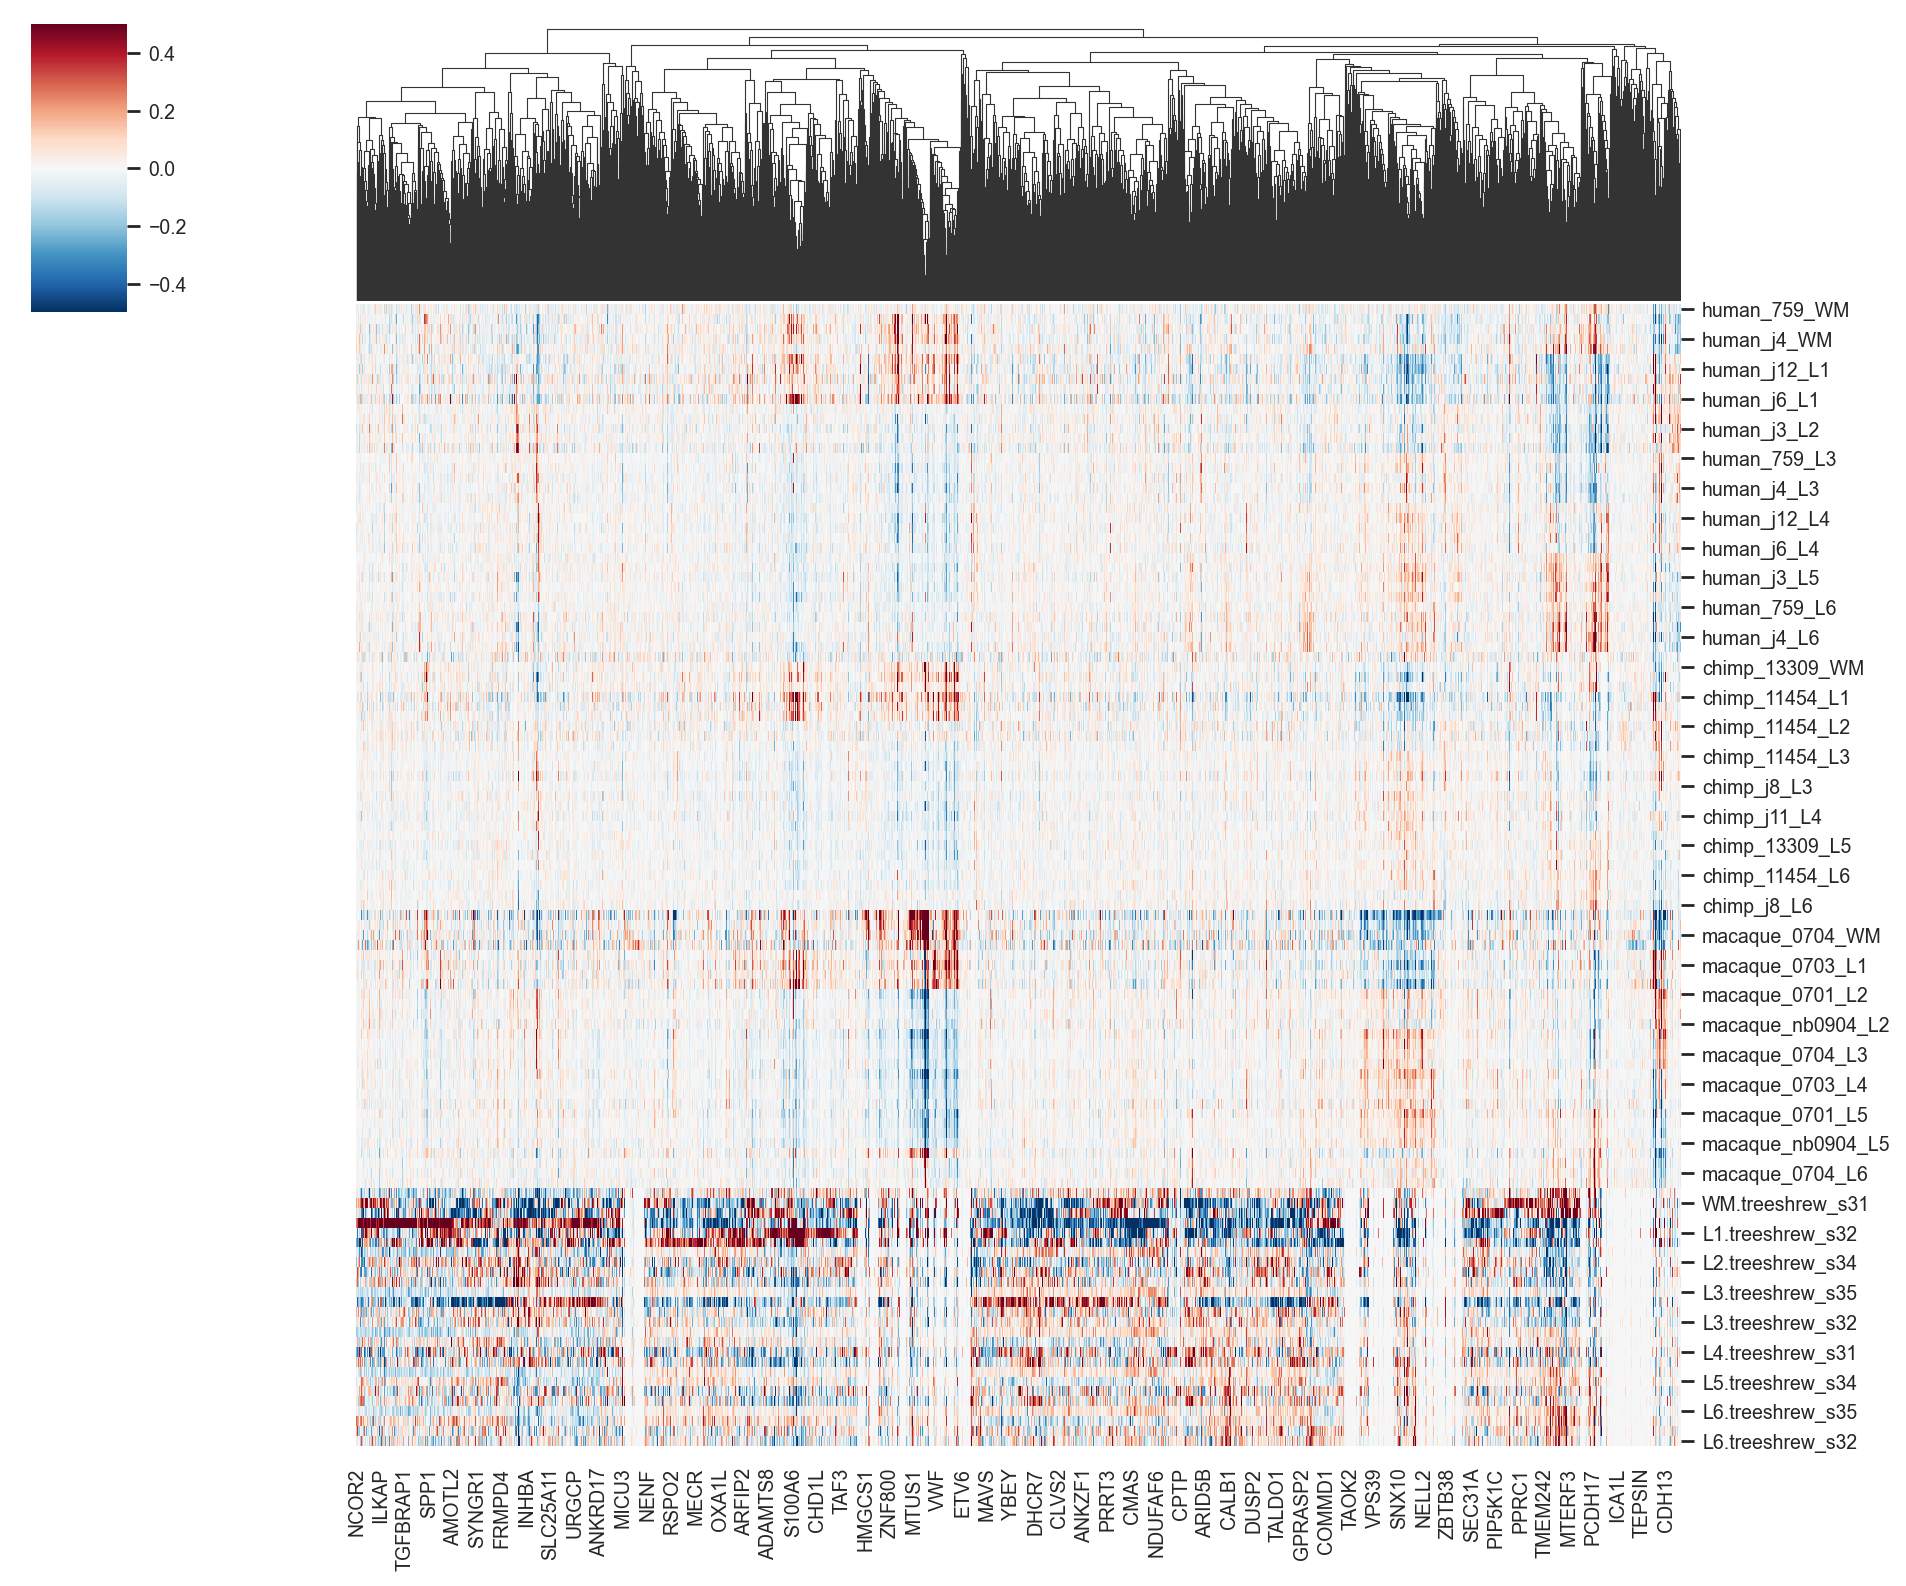

In [30]:
sns.set(font_scale=0.8)
sns.clustermap(df, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [20]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [21]:
labels.to_csv('./results/human_clusters_77.csv')

In [40]:
hs_labels_inter = hs_labels.loc[hs_genes_inter].sort_values()
hs_labels_inter

ADRA2A    0
FOXP2     0
SCUBE1    0
GRM5      0
RGS4      0
         ..
ETFB      3
FABP7     3
ZBTB18    3
SYNE1     3
FJX1      3
Name: 0, Length: 90, dtype: int64

<Axes: >

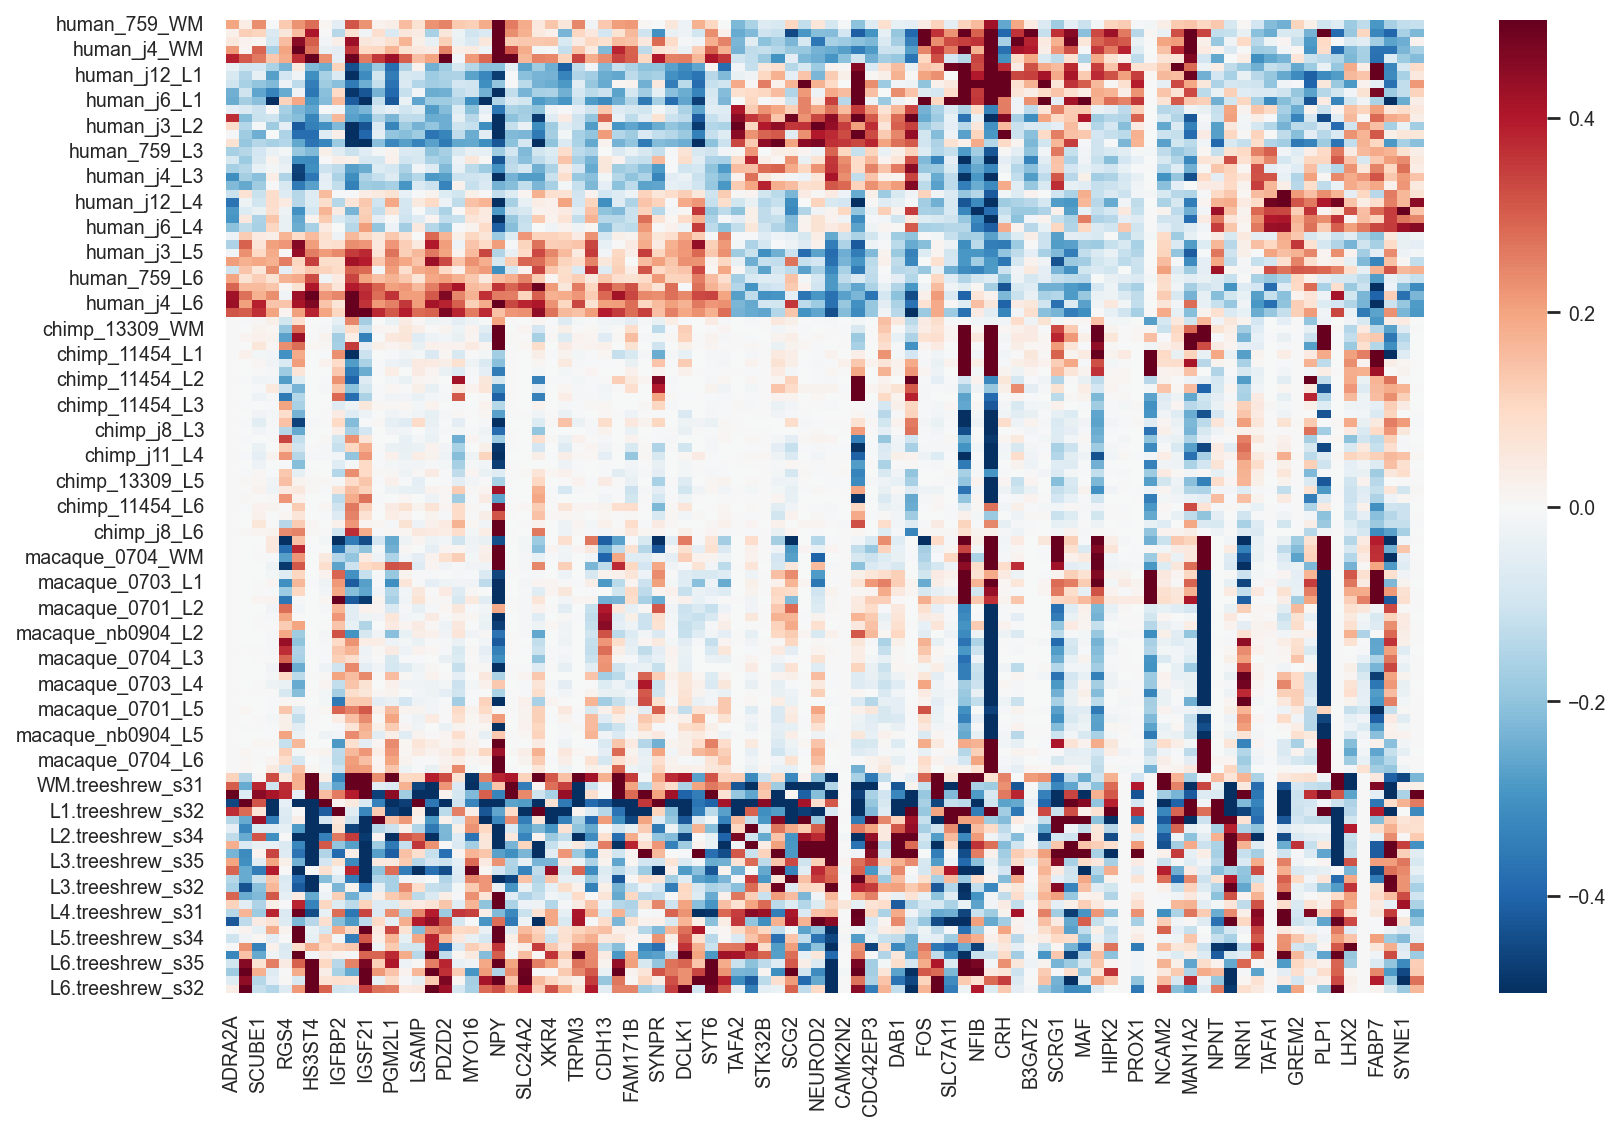

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[hs_labels_inter.index], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)

## Cluster profiles

In [42]:
df_annotation = df[hs_labels_inter.index].copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [43]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ADRA2A     FOXP2    SCUBE1      GRM5      RGS4      RGMA  \
condition layer                                                             
chimp     L1        0.0  0.006987 -0.000401 -0.016736 -0.186101  0.154567   
          L2        0.0 -0.002364 -0.018027  0.006991 -0.248340 -0.149645   
          L3        0.0 -0.003440 -0.024141 -0.009332  0.074302 -0.280505   
          L4        0.0 -0.003440 -0.028680  0.003714  0.167778 -0.145360   
          L5        0.0  0.002416  0.009625 -0.012056  0.137853  0.012312   

                   HS3ST4  PRICKLE2    IGFBP2  SERPINI1  ...     GREM2  \
condition layer                                          ...             
chimp     L1    -0.002324  0.004650  0.153067 -0.388745  ...  0.000000   
          L2    -0.002324 -0.006024  0.217741 -0.329566  ...  0.000000   
          L3    -0.003044  0.001381  0.028193 -0.116978  ...  0.001905   
          L4    -0.002757 -0.003785 -0.072505  0.031124  ...  0.001566   
          L5     0.003222 -0.000595 -0.055311  0.167237  ... -0.001157   

                      LPL      PLP1     SSTR1      LHX2      ETFB     FABP7  \
condition layer                                                               
chimp     L1     0.067230  0.030537 -0.000761  0.205694  0.148220  0.573633   
          L2     0.366460 -0.238532 -0.000761  0.190418 -0.040344  0.162551   
          L3     0.108658 -0.170405  0.001335  0.048584 -0.038414  0.008343   
          L4    -0.067057 -0.158117  0.003482 -0.055995  0.004832 -0.047810   
          L5    -0.140874 -0.199623 -0.001728 -0.089619 -0.031816 -0.149281   

                   ZBTB18     SYNE1      FJX1  
condition layer                                
chimp     L1    -0.154330 -0.011624 -0.000345  
          L2     0.229193  0.096819 -0.000345  
          L3     0.178206  0.077937 -0.001499  
          L4     0.129230  0.052186  0.001224  
          L5     0.023022  0.001706  0.002597  

[5 rows x 90 columns]

In [48]:
n_clusters = hs_labels_inter.unique().size
n_clusters

4

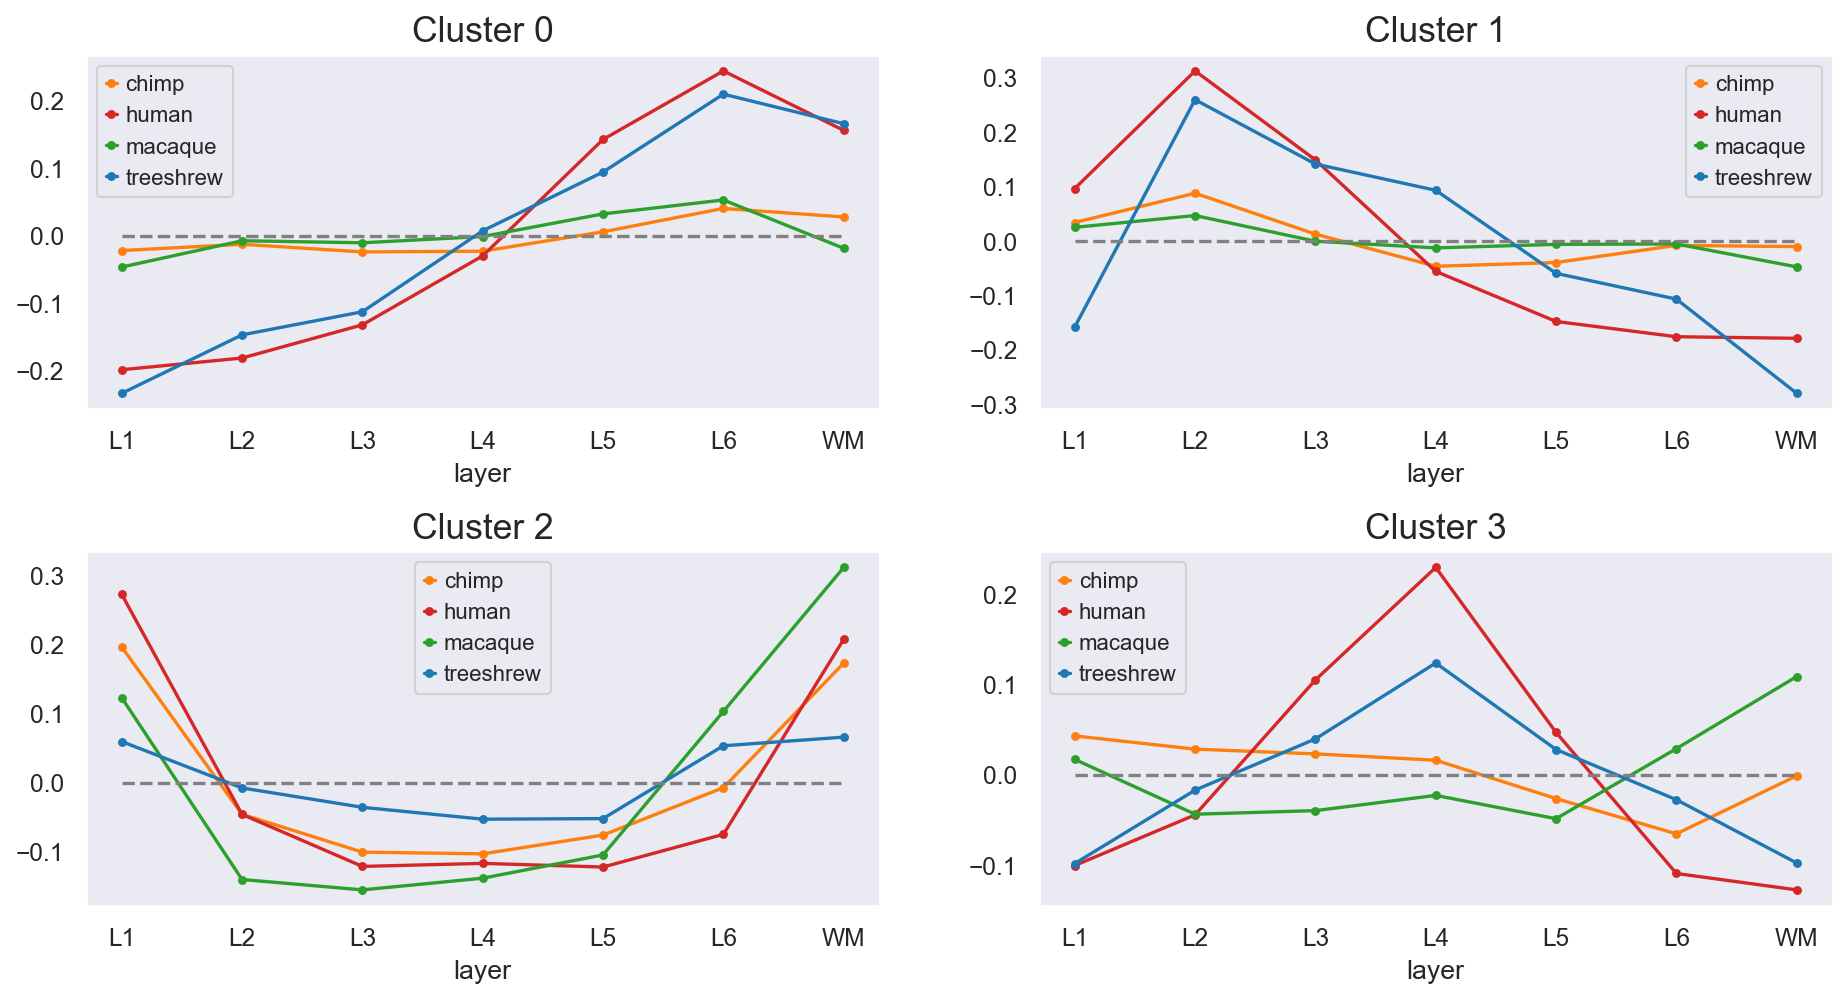

In [49]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(hs_labels_inter.unique(), axes.flatten()):
    genes = hs_labels_inter[hs_labels_inter == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [81]:
label = 3
hs_labels_inter[hs_labels_inter == label]
layer_mean['NPNT']

condition  layer
chimp      L1       0.020869
           L2      -0.073879
           L3      -0.022241
           L4       0.038330
           L5       0.045430
           L6      -0.043500
           WM       0.021738
human      L1      -0.096110
           L2      -0.235080
           L3       0.013004
           L4       0.262306
           L5       0.218172
           L6      -0.078922
           WM      -0.083370
macaque    L1      -0.001277
           L2      -0.000303
           L3      -0.000152
           L4      -0.000391
           L5       0.000249
           L6       0.003150
           WM      -0.001277
treeshrew  L1       0.831949
           L2      -0.078259
           L3      -0.105441
           L4      -0.210494
           L5      -0.301045
           L6       0.061213
           WM       0.013417
Name: NPNT, dtype: float64

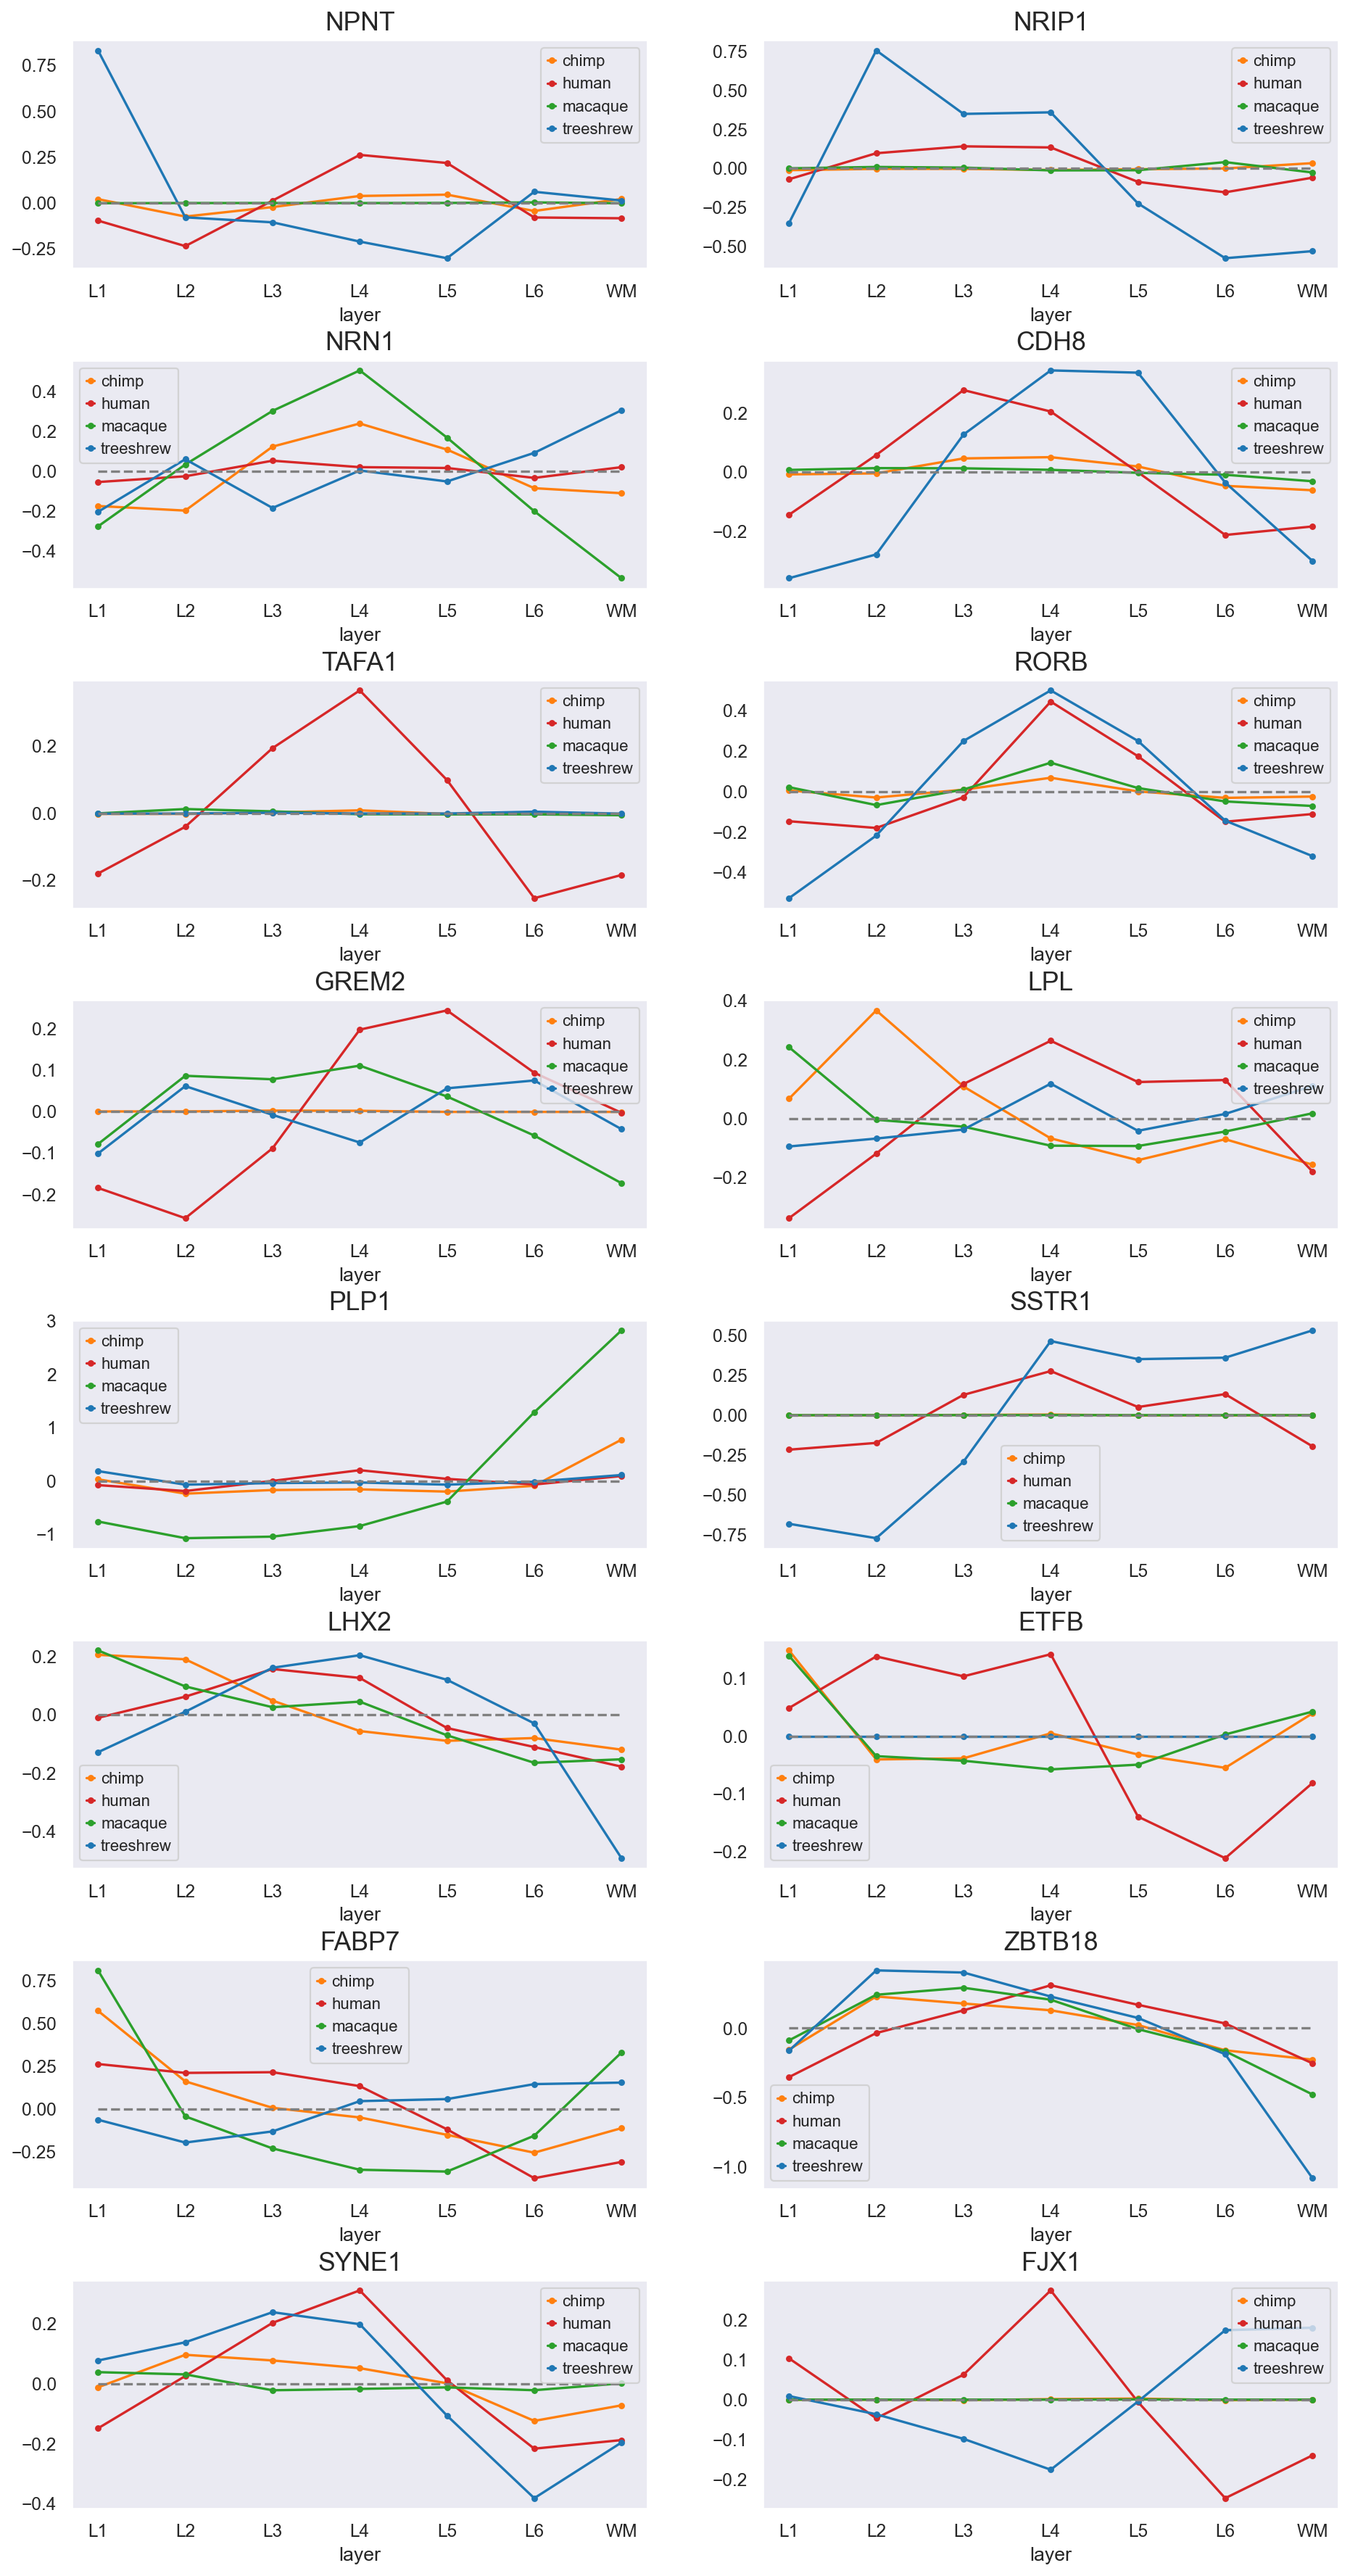

In [84]:
sns.set(font_scale=1)
label = 3
genes = hs_labels_inter[hs_labels_inter == label].index.tolist()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

for gene, ax in zip(genes, axes.flatten()):
    (
        layer_mean[gene]
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'{gene}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

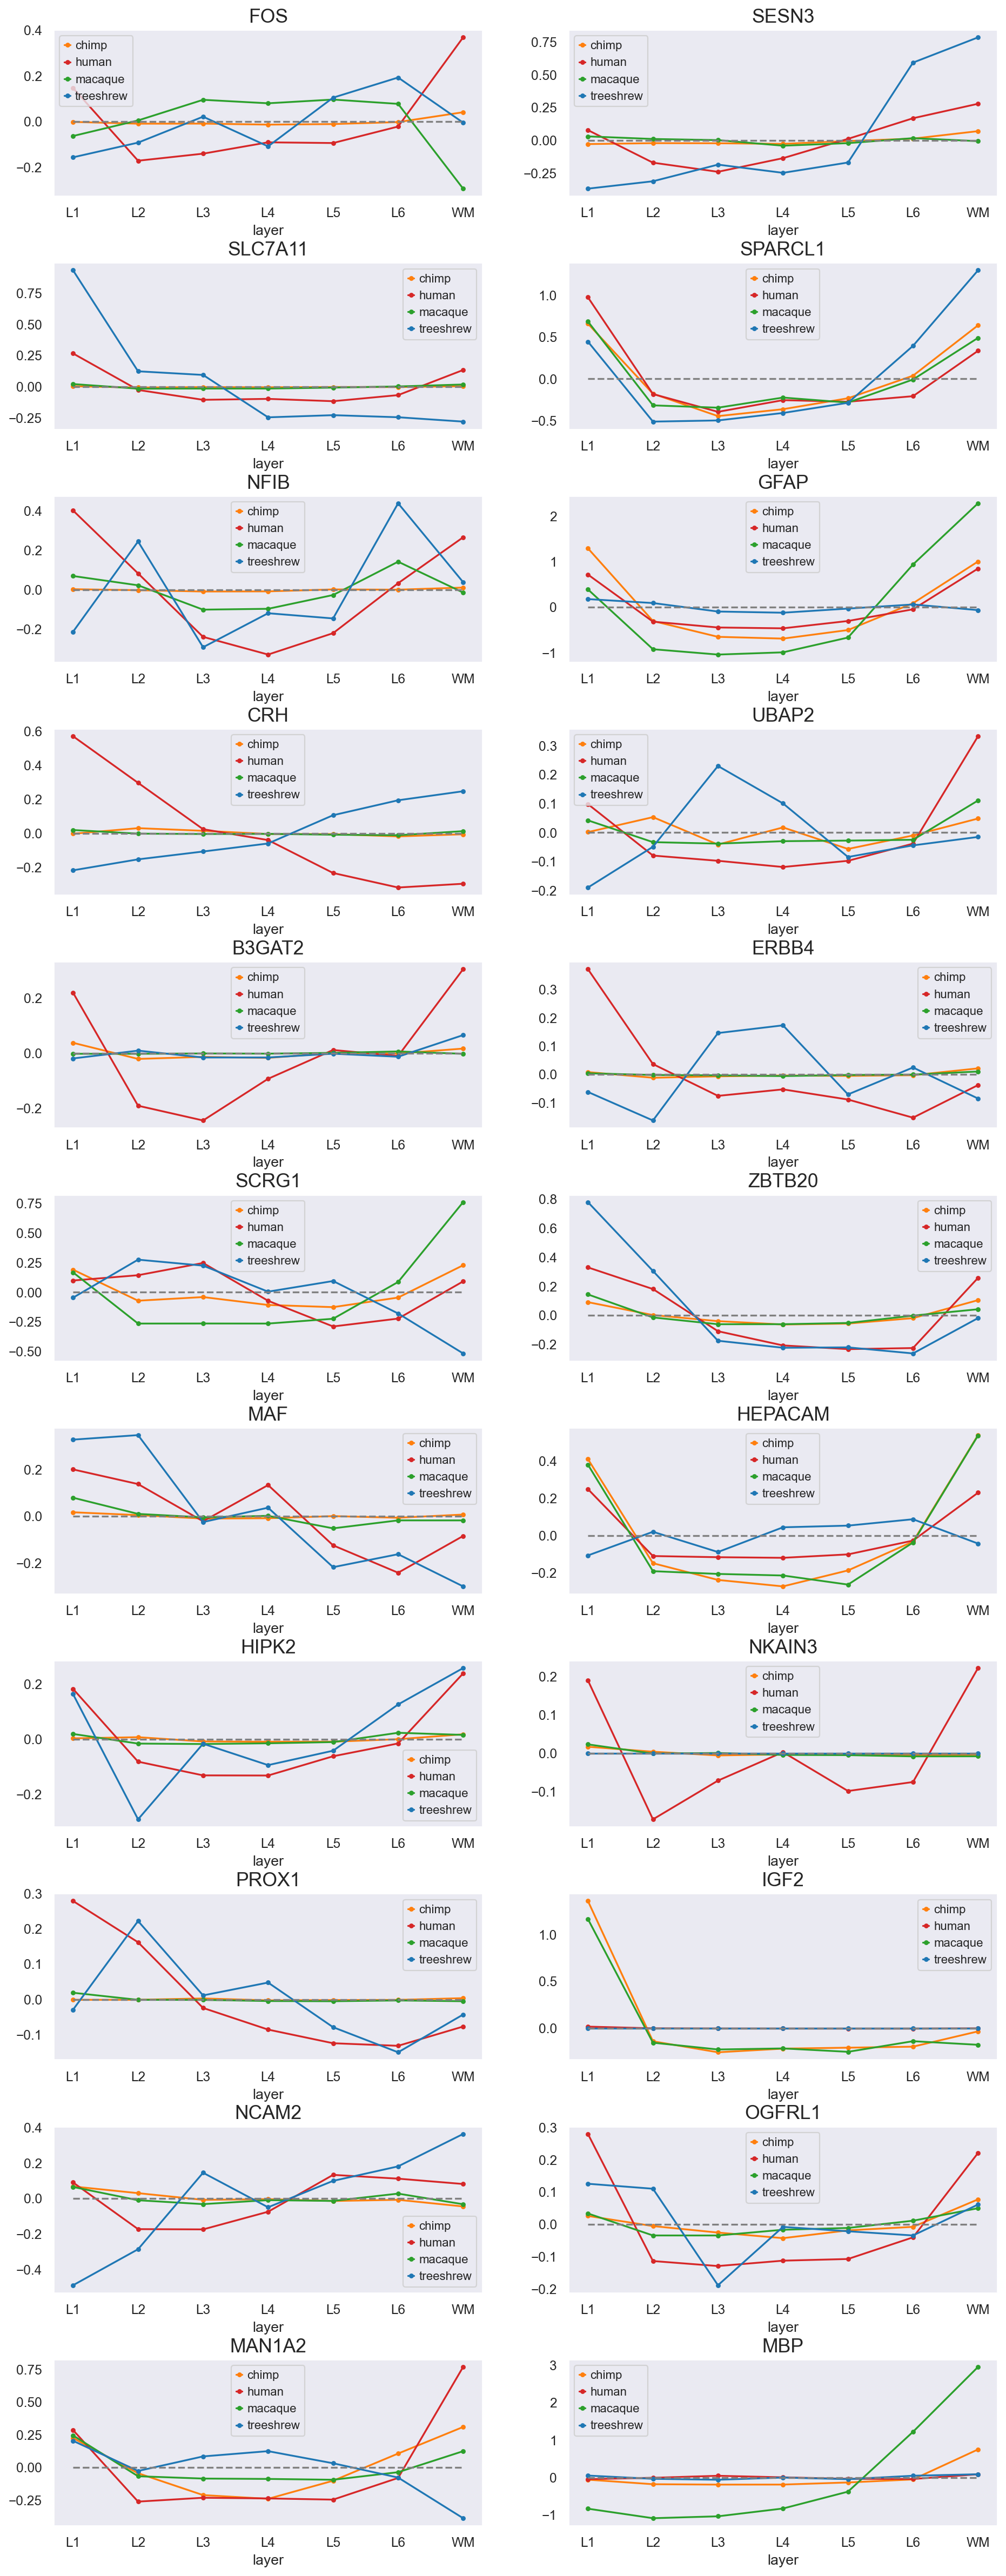

In [88]:
sns.set(font_scale=1)
label = 2
genes = hs_labels_inter[hs_labels_inter == label].index.tolist()
fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

for gene, ax in zip(genes, axes.flatten()):
    (
        layer_mean[gene]
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'{gene}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

Genes

In [54]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pb_mammals_filtered.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [73]:
import pickle
with open("./results/l1_distances.pkl", "rb") as file:
    l1_distances = pickle.load(file)

In [74]:
hc_l1 = l1_distances['hc_l1']

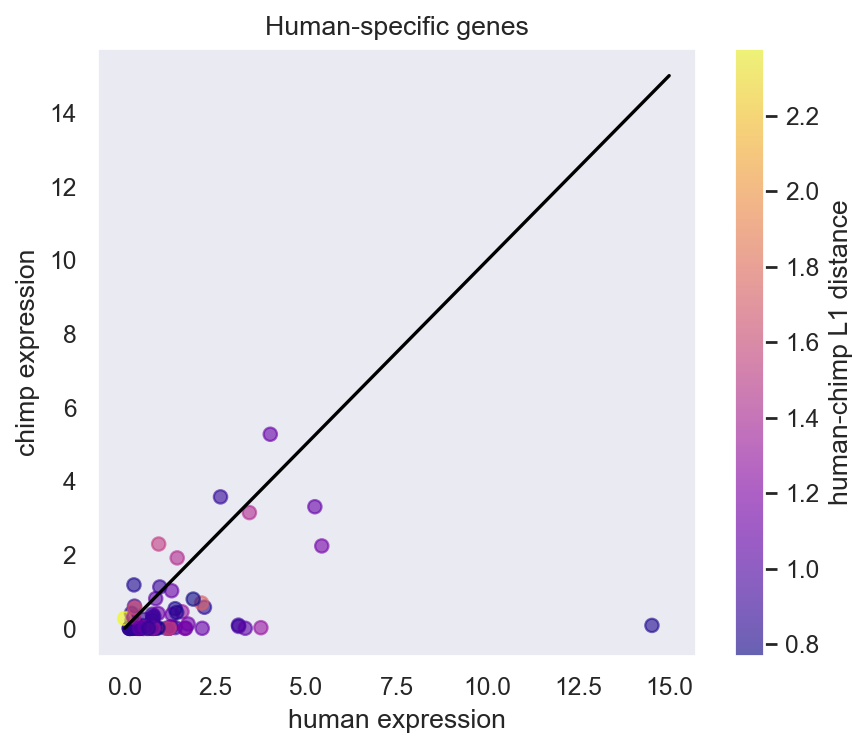

In [75]:
import matplotlib as mpl

plt.figure(figsize=(6, 5))
cmap = mpl.cm.plasma
genes = hs_labels_inter.index
human_expr = adata_pb[adata_pb.obs.condition == 'human', genes].X.mean(axis=0)
chimp_expr = adata_pb[adata_pb.obs.condition == 'chimp', genes].X.mean(axis=0)

plt.scatter(human_expr, chimp_expr, marker='o', c=hc_l1.loc[genes], alpha=0.6, cmap=cmap)
plt.plot([0, 15], [0, 15], 'black')
plt.xlabel('human expression')
plt.ylabel('chimp expression')
plt.title('Human-specific genes')
plt.grid(False)
#plt.xlim(-0.5, 20)
#plt.ylim(-0.5, 20)
plt.colorbar(label='human-chimp L1 distance')

In [76]:
adata_norm = adata_pb.copy()
sc.pp.normalize_total(adata_norm, target_sum=1e4)
sc.pp.log1p(adata_norm)

normalizing counts per cell
    finished (0:00:00)


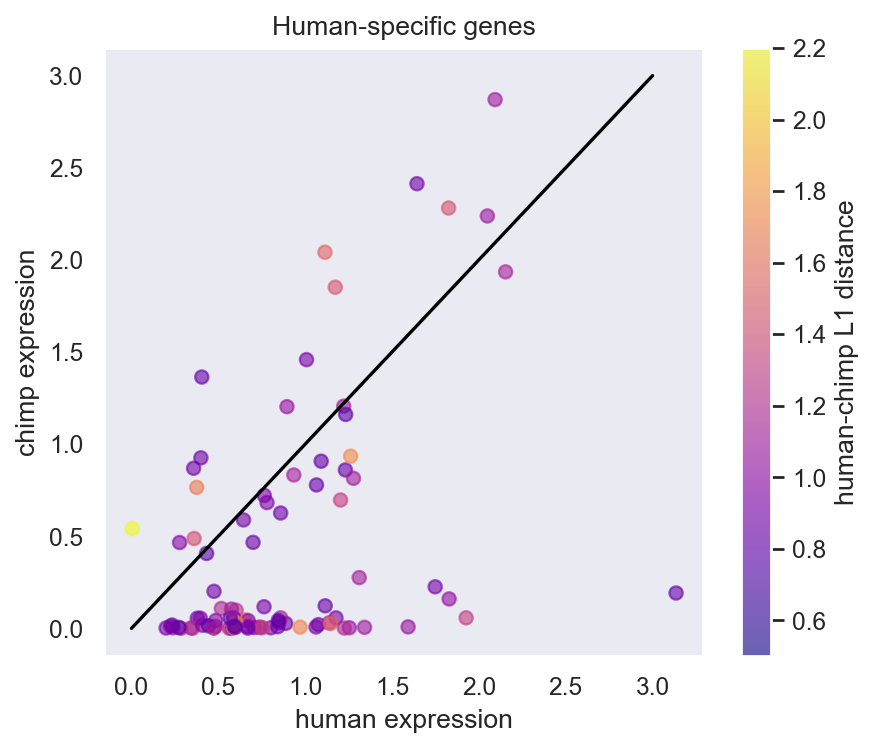

In [78]:
plt.figure(figsize=(6, 5))
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0.5, vmax=2.2, clip=True)

genes = hs_labels_inter.index
human_expr = adata_norm[adata_norm.obs.condition == 'human', genes].X.mean(axis=0)
chimp_expr = adata_norm[adata_norm.obs.condition == 'chimp', genes].X.mean(axis=0)

plt.scatter(human_expr, chimp_expr, marker='o', c=hc_l1.loc[genes], alpha=0.6, cmap=cmap, norm=norm)
plt.plot([0, 3], [0, 3], 'black')
plt.xlabel('human expression')
plt.ylabel('chimp expression')
plt.title('Human-specific genes')
plt.grid(False)
#plt.xlim(-0.5, 20)
#plt.ylim(-0.5, 20)
plt.colorbar(label='human-chimp L1 distance')